# Random Forest Model for Predicting Flood Risk in Metro Manila
## Using Weather and Geographic Data

### Problem Definition
Flooding is one of the most common and destructive natural hazards in the Philippines, particularly in Metro Manila. This project develops a machine learning model to predict daily flood risk based on weather and environmental data, helping local authorities anticipate high-risk days and improve disaster response.

### Project Objectives
- **Primary Model**: Random Forest Classifier for flood prediction (Binary Classification)
- **Comparative Models**: Logistic Regression and XGBoost for benchmarking
- **Dataset**: Metro Manila Flood Prediction Dataset (2016-2020) by Denver Magtibay
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Output**: Trained model with interpretable feature importance analysis

### Dataset Features
- **Predictors**: Rainfall (mm), Water Level (m), Soil Moisture (%), Elevation (m), Location (Station)
- **Target**: FloodOccurrence (1 = Flood, 0 = No Flood)
- **Scope**: ~7,300 records across Metro Manila weather stations (Quezon City, Marikina, Manila, Pasig)

## Section 1: Environment Setup & Imports
Install required packages and import libraries for a reproducible environment.

In [1]:
import subprocess
import sys

# Install required packages
packages = ['xgboost', 'shap']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             auc, precision_recall_curve, brier_score_loss)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import xgboost as xgb
import joblib
import json

# Data Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Python Version: {sys.version}")
print(f"Random State: {RANDOM_STATE}")

/workspaces/ElectivePIT/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!
Python Version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
Random State: 42


## Section 2: Data Acquisition & Loading
Load the Metro Manila Flood Prediction Dataset from the CSV file in the workspace.

In [2]:
def load_data(filepath):
    """
    Load flood prediction dataset from CSV.
    
    Args:
        filepath: Path to CSV file
    
    Returns:
        DataFrame with all columns properly typed
    """
    df = pd.read_csv(filepath)
    print(f"✓ Loaded dataset with shape: {df.shape}")
    return df

# Load the dataset
data_path = '/workspaces/ElectivePIT/Flood_Prediction_NCR_Philippines.csv'
df = load_data(data_path)

# Display basic info
print("\nDataset Info:")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

✓ Loaded dataset with shape: (7308, 7)

Dataset Info:
Columns: ['Date', 'Location', 'Rainfall_mm', 'WaterLevel_m', 'SoilMoisture_pct', 'Elevation_m', 'FloodOccurrence']

Data Types:
Date                 object
Location             object
Rainfall_mm         float64
WaterLevel_m        float64
SoilMoisture_pct    float64
Elevation_m           int64
FloodOccurrence       int64
dtype: object

Missing Values:
Date                0
Location            0
Rainfall_mm         0
WaterLevel_m        0
SoilMoisture_pct    0
Elevation_m         0
FloodOccurrence     0
dtype: int64


## Section 3: Initial Data Inspection & EDA
Explore the dataset structure, distributions, and relationships.

In [5]:
# First 5 rows
print("First 5 rows:")
print(df.head())

print("\n" + "="*60)
print("Dataset Statistics:")
print("="*60)
print(df.describe())

print("\n" + "="*60)
print("Target Variable (FloodOccurrence) Distribution:")
print("="*60)
print(df['FloodOccurrence'].value_counts())
print(f"\nClass Balance:")
print(f"  - No Flood (0): {(df['FloodOccurrence']==0).sum()} ({(df['FloodOccurrence']==0).mean()*100:.1f}%)")
print(f"  - Flood (1): {(df['FloodOccurrence']==1).sum()} ({(df['FloodOccurrence']==1).mean()*100:.1f}%)")

print("\n" + "="*60)
print("Locations in Dataset:")
print("="*60)
print(df['Location'].value_counts())

First 5 rows:
         Date     Location  Rainfall_mm  WaterLevel_m  SoilMoisture_pct  \
0  01/01/2016  Quezon City         12.0           0.5              15.3   
1  01/01/2016     Marikina         10.6           1.8              23.2   
2  01/01/2016       Manila          5.7           0.5              15.6   
3  01/01/2016        Pasig          3.7           0.5               5.0   
4  02/01/2016  Quezon City          3.4           0.5              13.3   

   Elevation_m  FloodOccurrence  
0           43                0  
1           15                0  
2            5                0  
3            5                0  
4           43                0  

Dataset Statistics:
       Rainfall_mm  WaterLevel_m  SoilMoisture_pct  Elevation_m  \
count  7308.000000   7308.000000       7308.000000  7308.000000   
mean     10.052874      1.266379         15.184989    17.000000   
std       7.101769      0.902239          5.994044    15.557414   
min       0.100000      0.500000          

In [ ]:
# EDA Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Target Distribution
df['FloodOccurrence'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Flood Occurrence Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('FloodOccurrence')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Flood (0)', 'Flood (1)'], rotation=0)

# 2. Rainfall Distribution
axes[0, 1].hist(df['Rainfall_mm'], bins=50, color='#3498db', edgecolor='black')
axes[0, 1].set_title('Rainfall Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Rainfall (mm)')
axes[0, 1].set_ylabel('Frequency')

# 3. Water Level by Flood Occurrence
df.boxplot(column='WaterLevel_m', by='FloodOccurrence', ax=axes[1, 0])
axes[1, 0].set_title('Water Level by Flood Occurrence', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('FloodOccurrence')
axes[1, 0].set_ylabel('Water Level (m)')
axes[1, 0].get_figure().suptitle('')

# 4. Soil Moisture by Flood Occurrence
df.boxplot(column='SoilMoisture_pct', by='FloodOccurrence', ax=axes[1, 1])
axes[1, 1].set_title('Soil Moisture by Flood Occurrence', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('FloodOccurrence')
axes[1, 1].set_ylabel('Soil Moisture (%)')
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

print("✓ EDA visualizations complete!")

In [ ]:
# Correlation Analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Correlation with Target (FloodOccurrence):")
print(correlation_matrix['FloodOccurrence'].sort_values(ascending=False))

## Section 4: Data Cleaning (Missing Values & Outliers)
Handle missing values, outliers, and prepare data for modeling.

In [3]:
df_clean = df.copy()

print("="*60)
print("BEFORE CLEANING")
print("="*60)
print(f"Shape: {df_clean.shape}")
print(f"Missing values:\n{df_clean.isnull().sum()}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")

# Remove duplicates if any
df_clean = df_clean.drop_duplicates()

# Handle missing values - for time series data, group by Location and forward fill
for col in ['Rainfall_mm', 'WaterLevel_m', 'SoilMoisture_pct']:
    if df_clean[col].isnull().sum() > 0:
        # Forward fill within each location
        df_clean[col] = df_clean.groupby('Location')[col].fillna(method='ffill')
        # Backward fill remaining
        df_clean[col] = df_clean[col].fillna(method='bfill')
        # Fill with median if still missing
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Handle outliers using IQR method for key features
def handle_outliers(data, columns, multiplier=1.5):
    """Cap outliers using IQR method"""
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        n_outliers_lower = (data[col] < lower_bound).sum()
        n_outliers_upper = (data[col] > upper_bound).sum()
        
        if n_outliers_lower > 0 or n_outliers_upper > 0:
            print(f"{col}: {n_outliers_lower} lower outliers, {n_outliers_upper} upper outliers")
            data[col] = data[col].clip(lower_bound, upper_bound)
    
    return data

df_clean = handle_outliers(df_clean, ['Rainfall_mm', 'WaterLevel_m', 'SoilMoisture_pct'])

print("\n" + "="*60)
print("AFTER CLEANING")
print("="*60)
print(f"Shape: {df_clean.shape}")
print(f"Missing values:\n{df_clean.isnull().sum()}")
print(f"✓ Data cleaning complete!")

BEFORE CLEANING
Shape: (7308, 7)
Missing values:
Date                0
Location            0
Rainfall_mm         0
WaterLevel_m        0
SoilMoisture_pct    0
Elevation_m         0
FloodOccurrence     0
dtype: int64
Duplicate rows: 0
Rainfall_mm: 0 lower outliers, 249 upper outliers
WaterLevel_m: 0 lower outliers, 129 upper outliers
SoilMoisture_pct: 0 lower outliers, 62 upper outliers

AFTER CLEANING
Shape: (7308, 7)
Missing values:
Date                0
Location            0
Rainfall_mm         0
WaterLevel_m        0
SoilMoisture_pct    0
Elevation_m         0
FloodOccurrence     0
dtype: int64
✓ Data cleaning complete!


## Section 5: Feature Engineering (Lag & Rolling Features)
Create temporal features including lag variables and moving averages, grouped by location.

In [4]:
def add_lag_features(df, columns, lags=[1, 3, 7]):
    """
    Create lag features grouped by location.
    
    Args:
        df: DataFrame with Date and Location columns
        columns: List of columns to create lags for
        lags: List of lag periods
    
    Returns:
        DataFrame with lag features added
    """
    df = df.copy()
    
    for col in columns:
        for lag in lags:
            lag_col_name = f'{col}_lag{lag}'
            df[lag_col_name] = df.groupby('Location')[col].shift(lag)
    
    return df

def add_rolling_features(df, columns, windows=[3, 7]):
    """
    Create rolling mean and sum features grouped by location.
    
    Args:
        df: DataFrame with Location column
        columns: List of columns to create rolling features for
        windows: List of window sizes
    
    Returns:
        DataFrame with rolling features added
    """
    df = df.copy()
    
    for col in columns:
        for window in windows:
            # Rolling mean
            mean_col_name = f'{col}_rolling_mean_{window}d'
            df[mean_col_name] = df.groupby('Location')[col].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            
            # Rolling sum
            sum_col_name = f'{col}_rolling_sum_{window}d'
            df[sum_col_name] = df.groupby('Location')[col].transform(
                lambda x: x.rolling(window=window, min_periods=1).sum()
            )
    
    return df

# Apply feature engineering
df_features = add_lag_features(df_clean, ['Rainfall_mm', 'WaterLevel_m', 'SoilMoisture_pct'], 
                               lags=[1, 3, 7])
df_features = add_rolling_features(df_features, ['Rainfall_mm', 'WaterLevel_m'], 
                                   windows=[3, 7])

# Fill NaN values created by lag/rolling features with 0 (for first records per location)
df_features = df_features.fillna(0)

print("="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"Original features: {len(df_clean.columns)}")
print(f"Total features after engineering: {len(df_features.columns)}")
print(f"New features added: {len(df_features.columns) - len(df_clean.columns)}")
print(f"\nNew feature columns:")
new_cols = [col for col in df_features.columns if col not in df_clean.columns]
for col in sorted(new_cols)[:10]:
    print(f"  - {col}")
print(f"  ... and {len(new_cols)-10} more")

print(f"\n✓ Shape after feature engineering: {df_features.shape}")

FEATURE ENGINEERING COMPLETE
Original features: 7
Total features after engineering: 24
New features added: 17

New feature columns:
  - Rainfall_mm_lag1
  - Rainfall_mm_lag3
  - Rainfall_mm_lag7
  - Rainfall_mm_rolling_mean_3d
  - Rainfall_mm_rolling_mean_7d
  - Rainfall_mm_rolling_sum_3d
  - Rainfall_mm_rolling_sum_7d
  - SoilMoisture_pct_lag1
  - SoilMoisture_pct_lag3
  - SoilMoisture_pct_lag7
  ... and 7 more

✓ Shape after feature engineering: (7308, 24)


## Section 6: Location Encoding & Temporal Features
Encode categorical locations and create temporal features.

In [5]:
# Convert Date to datetime
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

# Create temporal features
df_features['Day_of_Year'] = df_features['Date'].dt.dayofyear
df_features['Month'] = df_features['Date'].dt.month
df_features['Quarter'] = df_features['Date'].dt.quarter
df_features['Week_of_Year'] = df_features['Date'].dt.isocalendar().week
df_features['Day_of_Week'] = df_features['Date'].dt.dayofweek
df_features['Is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype(int)

# One-hot encode Location
location_dummies = pd.get_dummies(df_features['Location'], prefix='Location', drop_first=True)
df_features = pd.concat([df_features, location_dummies], axis=1)

print("Temporal Features Created:")
temporal_features = ['Day_of_Year', 'Month', 'Quarter', 'Week_of_Year', 'Day_of_Week', 'Is_Weekend']
for feat in temporal_features:
    print(f"  ✓ {feat}")

print("\nLocation Encoding (One-Hot):")
for col in location_dummies.columns:
    print(f"  ✓ {col}")

print(f"\n✓ Final dataset shape: {df_features.shape}")
print(f"Final columns: {len(df_features.columns)}")

# Display feature set
print("\nFinal Feature List (First 20):")
feature_cols = [col for col in df_features.columns if col not in ['Date', 'FloodOccurrence', 'Location']]
for i, col in enumerate(feature_cols[:20]):
    print(f"  {i+1}. {col}")
if len(feature_cols) > 20:
    print(f"  ... and {len(feature_cols)-20} more features")

Temporal Features Created:
  ✓ Day_of_Year
  ✓ Month
  ✓ Quarter
  ✓ Week_of_Year
  ✓ Day_of_Week
  ✓ Is_Weekend

Location Encoding (One-Hot):
  ✓ Location_Marikina
  ✓ Location_Pasig
  ✓ Location_Quezon City

✓ Final dataset shape: (7308, 33)
Final columns: 33

Final Feature List (First 20):
  1. Rainfall_mm
  2. WaterLevel_m
  3. SoilMoisture_pct
  4. Elevation_m
  5. Rainfall_mm_lag1
  6. Rainfall_mm_lag3
  7. Rainfall_mm_lag7
  8. WaterLevel_m_lag1
  9. WaterLevel_m_lag3
  10. WaterLevel_m_lag7
  11. SoilMoisture_pct_lag1
  12. SoilMoisture_pct_lag3
  13. SoilMoisture_pct_lag7
  14. Rainfall_mm_rolling_mean_3d
  15. Rainfall_mm_rolling_sum_3d
  16. Rainfall_mm_rolling_mean_7d
  17. Rainfall_mm_rolling_sum_7d
  18. WaterLevel_m_rolling_mean_3d
  19. WaterLevel_m_rolling_sum_3d
  20. WaterLevel_m_rolling_mean_7d
  ... and 10 more features


## Section 7: Prepare Features & Train/Validation/Test Split
Create feature matrix and split data into 70% training, 15% validation, and 15% testing sets.

In [6]:
# Prepare feature matrix and target vector
X = df_features.drop(['Date', 'FloodOccurrence', 'Location'], axis=1)
y = df_features['FloodOccurrence']

print("="*60)
print("FEATURE MATRIX PREPARATION")
print("="*60)
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Feature names ({len(X.columns)} total):")
for i, col in enumerate(X.columns):
    print(f"  {i+1}. {col}")

# Split: 70% train+val, 30% test first
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

# Then split remaining into 70% train (out of 85%) and 15% validation
# 70/85 ≈ 0.8235
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=RANDOM_STATE, stratify=y_temp
)

print("\n" + "="*60)
print("DATA SPLIT SUMMARY (70% / 15% / 15%)")
print("="*60)
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"  Training:   {(y_train==1).sum()} floods, {(y_train==0).sum()} no-floods")
print(f"  Validation: {(y_val==1).sum()} floods, {(y_val==0).sum()} no-floods")
print(f"  Test:       {(y_test==1).sum()} floods, {(y_test==0).sum()} no-floods")

print(f"\n✓ Data split complete!")

FEATURE MATRIX PREPARATION
Features (X) shape: (7308, 30)
Target (y) shape: (7308,)
Feature names (30 total):
  1. Rainfall_mm
  2. WaterLevel_m
  3. SoilMoisture_pct
  4. Elevation_m
  5. Rainfall_mm_lag1
  6. Rainfall_mm_lag3
  7. Rainfall_mm_lag7
  8. WaterLevel_m_lag1
  9. WaterLevel_m_lag3
  10. WaterLevel_m_lag7
  11. SoilMoisture_pct_lag1
  12. SoilMoisture_pct_lag3
  13. SoilMoisture_pct_lag7
  14. Rainfall_mm_rolling_mean_3d
  15. Rainfall_mm_rolling_sum_3d
  16. Rainfall_mm_rolling_mean_7d
  17. Rainfall_mm_rolling_sum_7d
  18. WaterLevel_m_rolling_mean_3d
  19. WaterLevel_m_rolling_sum_3d
  20. WaterLevel_m_rolling_mean_7d
  21. WaterLevel_m_rolling_sum_7d
  22. Day_of_Year
  23. Month
  24. Quarter
  25. Week_of_Year
  26. Day_of_Week
  27. Is_Weekend
  28. Location_Marikina
  29. Location_Pasig
  30. Location_Quezon City

DATA SPLIT SUMMARY (70% / 15% / 15%)
Training set:   5,114 samples (70.0%)
Validation set: 1,097 samples (15.0%)
Test set:       1,097 samples (15.0%)

C

## Section 8: Model Evaluation Utilities
Define functions for evaluating and comparing models.

In [7]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name="Model"):
    """
    Comprehensive model evaluation on train/val/test sets.
    
    Returns:
        Dictionary with all metrics
    """
    results = {
        'model_name': model_name,
        'train': {},
        'validation': {},
        'test': {}
    }
    
    # Training set evaluation
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    results['train']['accuracy'] = accuracy_score(y_train, y_train_pred)
    results['train']['precision'] = precision_score(y_train, y_train_pred, zero_division=0)
    results['train']['recall'] = recall_score(y_train, y_train_pred, zero_division=0)
    results['train']['f1'] = f1_score(y_train, y_train_pred, zero_division=0)
    results['train']['roc_auc'] = roc_auc_score(y_train, y_train_proba)
    
    # Validation set evaluation
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    results['validation']['accuracy'] = accuracy_score(y_val, y_val_pred)
    results['validation']['precision'] = precision_score(y_val, y_val_pred, zero_division=0)
    results['validation']['recall'] = recall_score(y_val, y_val_pred, zero_division=0)
    results['validation']['f1'] = f1_score(y_val, y_val_pred, zero_division=0)
    results['validation']['roc_auc'] = roc_auc_score(y_val, y_val_proba)
    
    # Test set evaluation
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    results['test']['accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test']['precision'] = precision_score(y_test, y_test_pred, zero_division=0)
    results['test']['recall'] = recall_score(y_test, y_test_pred, zero_division=0)
    results['test']['f1'] = f1_score(y_test, y_test_pred, zero_division=0)
    results['test']['roc_auc'] = roc_auc_score(y_test, y_test_proba)
    results['test']['brier'] = brier_score_loss(y_test, y_test_proba)
    
    # Store predictions for visualization
    results['predictions'] = {
        'train': y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred,
        'train_proba': y_train_proba,
        'val_proba': y_val_proba,
        'test_proba': y_test_proba
    }
    
    results['actual'] = {
        'train': y_train.values,
        'val': y_val.values,
        'test': y_test.values
    }
    
    return results

def print_evaluation_report(results):
    """Print formatted evaluation report."""
    print(f"\n{'='*70}")
    print(f"MODEL: {results['model_name']}")
    print(f"{'='*70}")
    
    for dataset_name in ['train', 'validation', 'test']:
        if dataset_name not in results:
            continue
        metrics = results[dataset_name]
        print(f"\n{dataset_name.upper()} SET:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1']:.4f}")
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
        if 'brier' in metrics:
            print(f"  Brier:     {metrics['brier']:.4f}")

# Store all model results for comparison
all_results = {}

## Section 9: Baseline Model - Logistic Regression
Train and evaluate logistic regression as a baseline model.

In [11]:
# Scale features for Logistic Regression
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
print("Training Logistic Regression Baseline Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_results = evaluate_model(lr_model, X_train_scaled, X_val_scaled, X_test_scaled, 
                            y_train, y_val, y_test, "Logistic Regression")
all_results['Logistic Regression'] = lr_results
print_evaluation_report(lr_results)

Training Logistic Regression Baseline Model...

MODEL: Logistic Regression

TRAIN SET:
  Accuracy:  0.9709
  Precision: 0.3817
  Recall:    1.0000
  F1-Score:  0.5526
  ROC-AUC:   0.9956

VALIDATION SET:
  Accuracy:  0.9754
  Precision: 0.4255
  Recall:    1.0000
  F1-Score:  0.5970
  ROC-AUC:   0.9956

TEST SET:
  Accuracy:  0.9754
  Precision: 0.4255
  Recall:    1.0000
  F1-Score:  0.5970
  ROC-AUC:   0.9965
  Brier:     0.0181


## Section 10: Random Forest - Hyperparameter Tuning with Grid Search
Train and optimize the primary Random Forest model with GridSearchCV.

In [1]:
print("\n" + "="*70)
print("RANDOM FOREST - HYPERPARAMETER TUNING WITH SMOTE")
print("="*70)

# Convert to numpy arrays to avoid SMOTE pandas dtype issues
X_train_np = X_train.values
y_train_np = y_train.values

# Apply SMOTE to training data to handle class imbalance
print("Applying SMOTE to training data...")
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_np, y_train_np)
print(f"Training data shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_smote)}")

# Define enhanced hyperparameter grid
param_grid_rf = {
    'n_estimators': [150, 250, 300],
    'max_depth': [15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'min_weight_fraction_leaf': [0.0, 0.01]
}

# Grid Search with F1 as primary scoring metric
print("Running GridSearchCV with SMOTE data (this may take several minutes)...")
rf_grid = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1)
gs_rf = GridSearchCV(rf_grid, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_rf.fit(X_train_smote, y_train_smote)

print(f"\n✓ Grid Search Complete!")
print(f"Best Parameters: {gs_rf.best_params_}")
print(f"Best CV F1-Score: {gs_rf.best_score_:.4f}")

# Best Random Forest model
rf_model = gs_rf.best_estimator_

# Evaluate on original (non-SMOTE) data
rf_results = evaluate_model(rf_model, X_train, X_val, X_test, 
                            y_train, y_val, y_test, "Random Forest (SMOTE + GridSearch)")
all_results['Random Forest'] = rf_results
print_evaluation_report(rf_results)

# Find optimal threshold for F1 score
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION FOR F1 SCORE")
print("="*70)
y_val_proba = rf_model.predict_proba(X_val)[:, 1]

best_f1 = 0
best_threshold = 0.5
f1_scores = []
thresholds = np.arange(0.1, 0.9, 0.05)

for threshold in thresholds:
    y_val_pred_tuned = (y_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred_tuned, zero_division=0)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 score at best threshold: {best_f1:.4f}")

# Recompute test results with optimal threshold
y_test_proba_opt = rf_model.predict_proba(X_test)[:, 1]
y_test_pred_opt = (y_test_proba_opt >= best_threshold).astype(int)
rf_results['test']['f1_optimized'] = f1_score(y_test, y_test_pred_opt, zero_division=0)
rf_results['test']['precision_optimized'] = precision_score(y_test, y_test_pred_opt, zero_division=0)
rf_results['test']['recall_optimized'] = recall_score(y_test, y_test_pred_opt, zero_division=0)
print(f"\nTest Set Performance with Optimal Threshold (t={best_threshold:.2f}):")
print(f"  Precision: {rf_results['test']['precision_optimized']:.4f}")
print(f"  Recall:    {rf_results['test']['recall_optimized']:.4f}")
print(f"  F1-Score:  {rf_results['test']['f1_optimized']:.4f}")

# Store optimal threshold
rf_model.best_threshold = best_threshold


RANDOM FOREST - HYPERPARAMETER TUNING WITH SMOTE


NameError: name 'X_train' is not defined

In [ ]:
# Install SMOTE for handling class imbalance
import subprocess
import sys
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Installing imbalanced-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE

print("✓ SMOTE library loaded successfully!")


## Section 11: XGBoost - Comparative Model
Train XGBoost classifier for model comparison.

In [13]:
print("\n" + "="*70)
print("XGBOOST - COMPARATIVE MODEL")
print("="*70)

# Scale features for XGBoost
X_train_xgb = scaler.fit_transform(X_train)
X_val_xgb = scaler.transform(X_val)
X_test_xgb = scaler.transform(X_test)

# Train XGBoost
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # Handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              verbose=False)

# Evaluate
xgb_results = evaluate_model(xgb_model, X_train_xgb, X_val_xgb, X_test_xgb,
                             y_train, y_val, y_test, "XGBoost")
all_results['XGBoost'] = xgb_results
print_evaluation_report(xgb_results)


XGBOOST - COMPARATIVE MODEL
Training XGBoost model...

MODEL: XGBoost

TRAIN SET:
  Accuracy:  0.9994
  Precision: 0.9684
  Recall:    1.0000
  F1-Score:  0.9840
  ROC-AUC:   1.0000

VALIDATION SET:
  Accuracy:  0.9854
  Precision: 0.5625
  Recall:    0.9000
  F1-Score:  0.6923
  ROC-AUC:   0.9941

TEST SET:
  Accuracy:  0.9900
  Precision: 0.6667
  Recall:    0.9000
  F1-Score:  0.7660
  ROC-AUC:   0.9963
  Brier:     0.0077

MODEL: XGBoost

TRAIN SET:
  Accuracy:  0.9994
  Precision: 0.9684
  Recall:    1.0000
  F1-Score:  0.9840
  ROC-AUC:   1.0000

VALIDATION SET:
  Accuracy:  0.9854
  Precision: 0.5625
  Recall:    0.9000
  F1-Score:  0.6923
  ROC-AUC:   0.9941

TEST SET:
  Accuracy:  0.9900
  Precision: 0.6667
  Recall:    0.9000
  F1-Score:  0.7660
  ROC-AUC:   0.9963
  Brier:     0.0077


## Section 12: Model Comparison Summary
Compare all three models on the test set.


MODEL COMPARISON - TEST SET PERFORMANCE

              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression  0.975387   0.425532    1.00  0.597015 0.996472
      Random Forest  0.989973   0.655172    0.95  0.775510 0.997168
            XGBoost  0.989973   0.666667    0.90  0.765957 0.996286


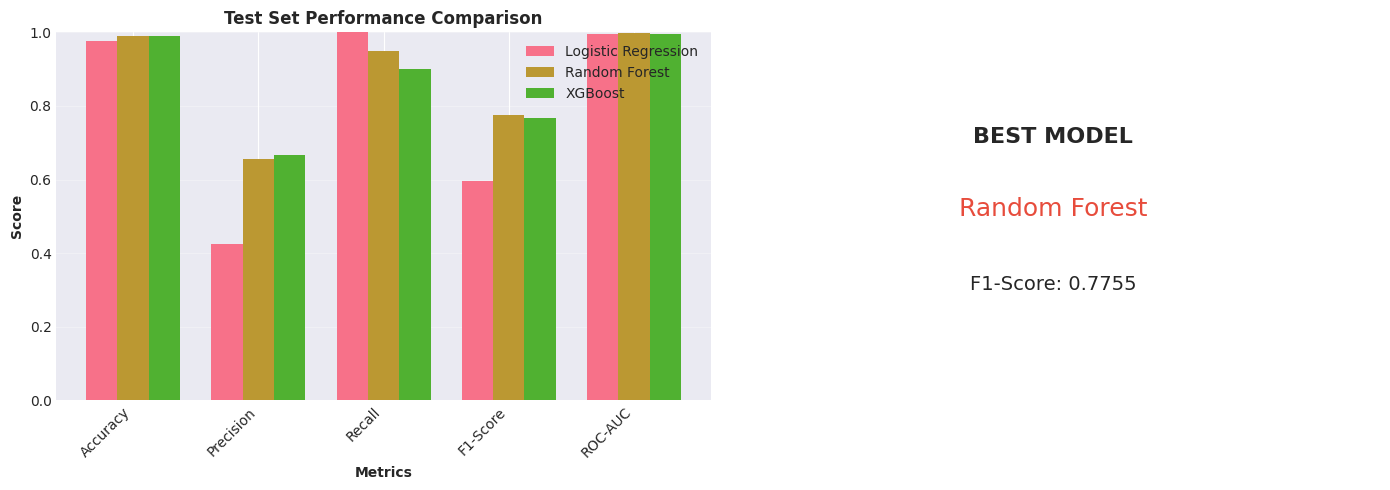


✓ Best Model: Random Forest (F1-Score: 0.7755)


In [15]:
# Create comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[m]['test']['accuracy'] for m in all_results.keys()],
    'Precision': [all_results[m]['test']['precision'] for m in all_results.keys()],
    'Recall': [all_results[m]['test']['recall'] for m in all_results.keys()],
    'F1-Score': [all_results[m]['test']['f1'] for m in all_results.keys()],
    'ROC-AUC': [all_results[m]['test']['roc_auc'] for m in all_results.keys()]
})

print("\n" + comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(all_results.keys()):
    values = [all_results[model]['test'][k] for k in metric_keys]
    axes[0].bar(x + i*width, values, width, label=model)

axes[0].set_xlabel('Metrics', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Test Set Performance Comparison', fontweight='bold', fontsize=12)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_f1 = comparison_df['F1-Score'].max()
axes[1].text(0.5, 0.7, 'BEST MODEL', ha='center', fontsize=16, fontweight='bold')
axes[1].text(0.5, 0.5, best_model_name, ha='center', fontsize=18, color='#e74c3c')
axes[1].text(0.5, 0.3, f'F1-Score: {best_f1:.4f}', ha='center', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

## Section 13: Confusion Matrix & Classification Report
Detailed analysis of the best model's predictions.

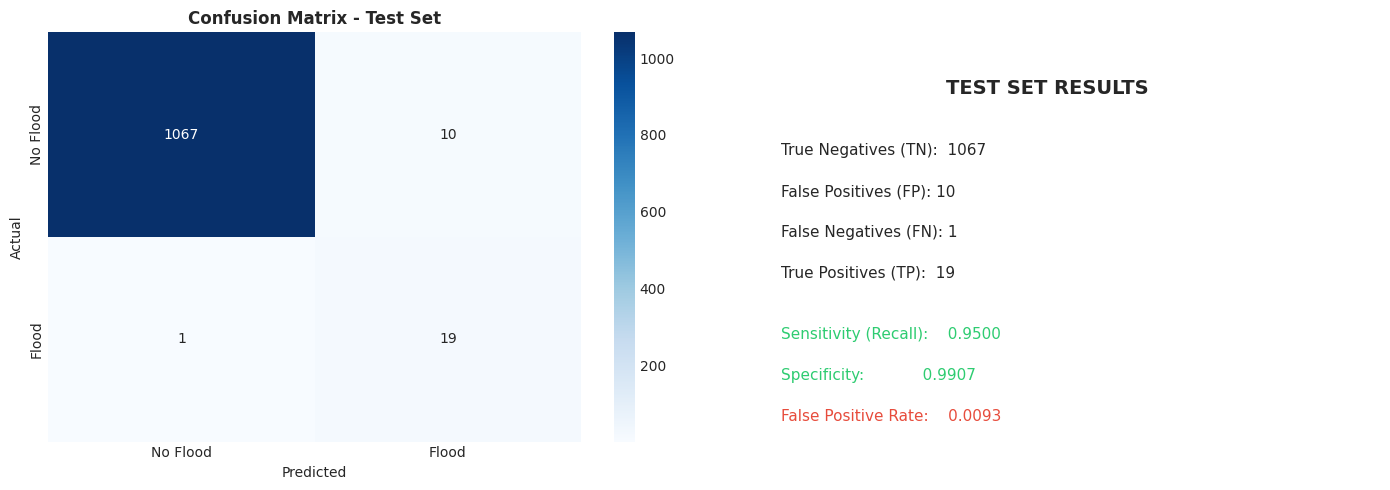


CLASSIFICATION REPORT - RANDOM FOREST (TEST SET)
              precision    recall  f1-score   support

    No Flood       1.00      0.99      0.99      1077
       Flood       0.66      0.95      0.78        20

    accuracy                           0.99      1097
   macro avg       0.83      0.97      0.89      1097
weighted avg       0.99      0.99      0.99      1097



In [16]:
# Use Random Forest as the best model for detailed analysis
best_model = rf_model
best_results = rf_results

# Confusion Matrix
y_test_pred = best_results['predictions']['test']
cm = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
axes[0].set_title('Confusion Matrix - Test Set', fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Classification metrics
tn, fp, fn, tp = cm.ravel()
axes[1].text(0.5, 0.85, 'TEST SET RESULTS', ha='center', fontsize=14, fontweight='bold')
axes[1].text(0.1, 0.70, f'True Negatives (TN):  {tn}', ha='left', fontsize=11)
axes[1].text(0.1, 0.60, f'False Positives (FP): {fp}', ha='left', fontsize=11)
axes[1].text(0.1, 0.50, f'False Negatives (FN): {fn}', ha='left', fontsize=11)
axes[1].text(0.1, 0.40, f'True Positives (TP):  {tp}', ha='left', fontsize=11)
axes[1].text(0.1, 0.25, f'Sensitivity (Recall):    {tp/(tp+fn):.4f}', ha='left', fontsize=11, color='#2ecc71')
axes[1].text(0.1, 0.15, f'Specificity:            {tn/(tn+fp):.4f}', ha='left', fontsize=11, color='#2ecc71')
axes[1].text(0.1, 0.05, f'False Positive Rate:    {fp/(fp+tn):.4f}', ha='left', fontsize=11, color='#e74c3c')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT - RANDOM FOREST (TEST SET)")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=['No Flood', 'Flood']))

## Section 14: ROC & Precision-Recall Curves
Analyze model performance at different probability thresholds.

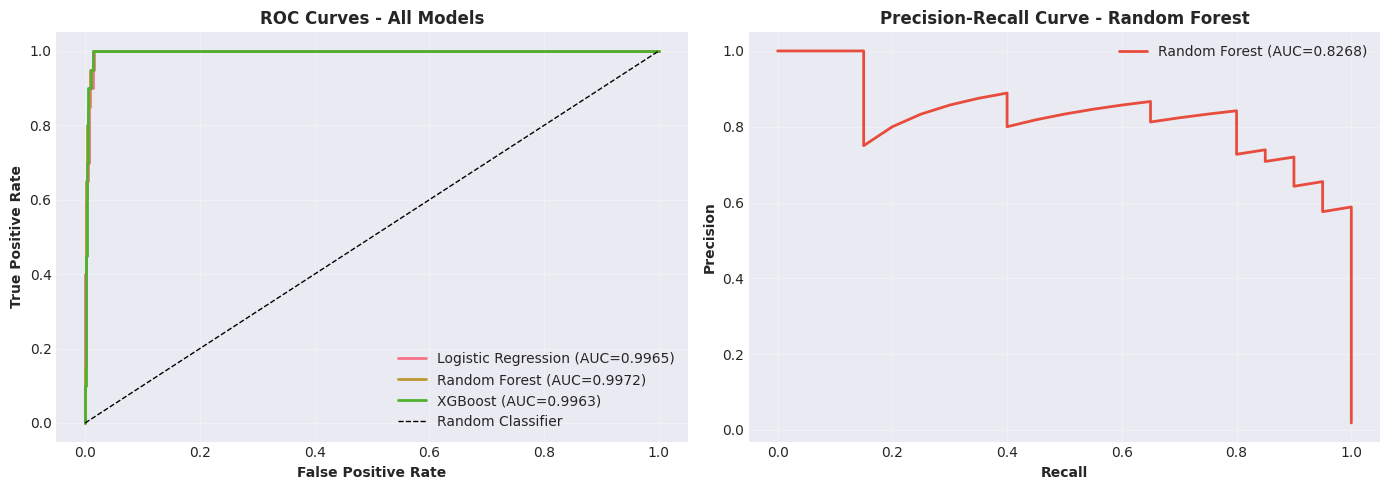

✓ ROC-AUC (Test): 0.9972
✓ PR-AUC (Test):  0.8268


In [17]:
# Get probabilities
y_test_proba = best_results['predictions']['test_proba']

# ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve for all models
for model_name in all_results.keys():
    y_pred_proba = all_results[model_name]['predictions']['test_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.4f})', linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('ROC Curves - All Models', fontweight='bold', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curve (Random Forest)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)
axes[1].plot(recall, precision, linewidth=2, label=f'Random Forest (AUC={pr_auc:.4f})', color='#e74c3c')
axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_ylabel('Precision', fontweight='bold')
axes[1].set_title('Precision-Recall Curve - Random Forest', fontweight='bold', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ ROC-AUC (Test): {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"✓ PR-AUC (Test):  {pr_auc:.4f}")

## Section 15: Feature Importance Analysis
Identify the most important predictors for flood occurrence.

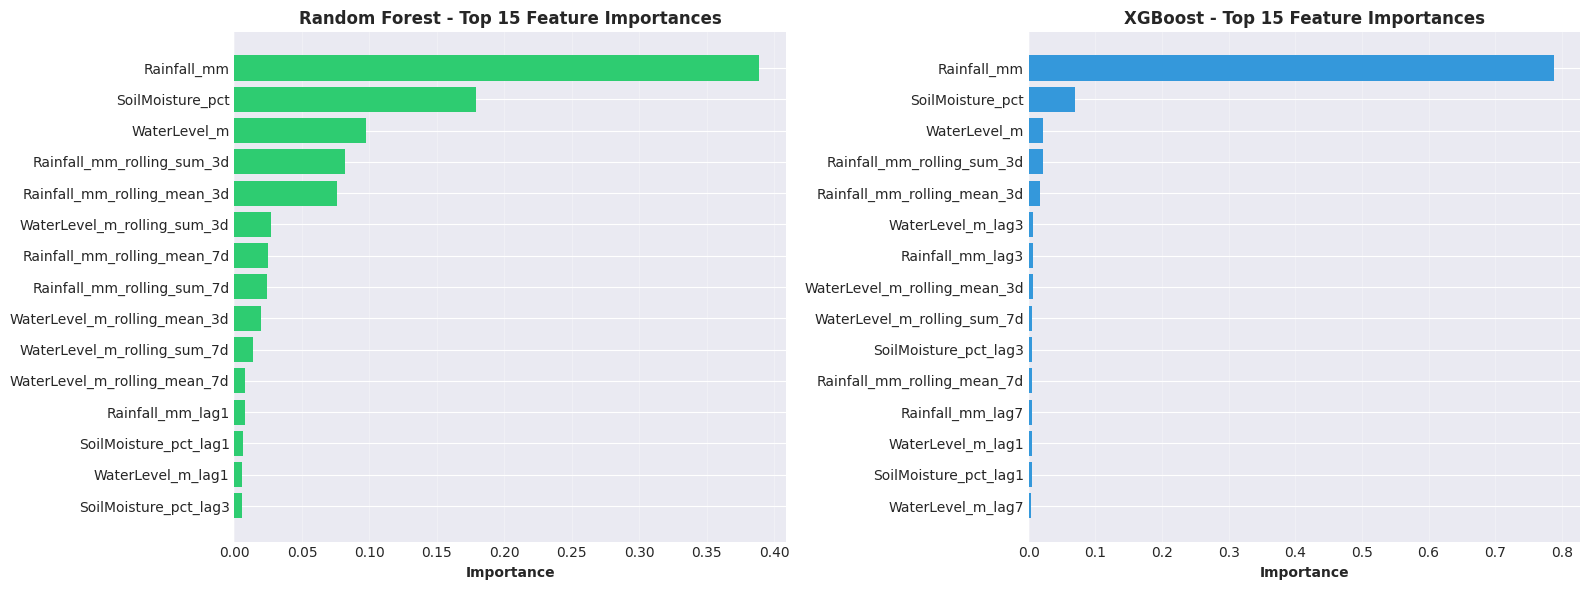


RANDOM FOREST - TOP 15 MOST IMPORTANT FEATURES
 1. Rainfall_mm                              0.388998
 2. SoilMoisture_pct                         0.178878
 3. WaterLevel_m                             0.097433
 4. Rainfall_mm_rolling_sum_3d               0.081926
 5. Rainfall_mm_rolling_mean_3d              0.075869
 6. WaterLevel_m_rolling_sum_3d              0.027056
 7. Rainfall_mm_rolling_mean_7d              0.025112
 8. Rainfall_mm_rolling_sum_7d               0.024239
 9. WaterLevel_m_rolling_mean_3d             0.019658
10. WaterLevel_m_rolling_sum_7d              0.014047
11. WaterLevel_m_rolling_mean_7d             0.008063
12. Rainfall_mm_lag1                         0.008033
13. SoilMoisture_pct_lag1                    0.006087
14. WaterLevel_m_lag1                        0.005524
15. SoilMoisture_pct_lag3                    0.005266

XGBOOST - TOP 15 MOST IMPORTANT FEATURES
 1. Rainfall_mm                              0.787843
 2. SoilMoisture_pct                         0

In [18]:
# Random Forest Feature Importance
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[-15:]  # Top 15 features

# XGBoost Feature Importance
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[-15:]  # Top 15 features

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
axes[0].barh(range(len(rf_indices)), rf_importances[rf_indices], color='#2ecc71')
axes[0].set_yticks(range(len(rf_indices)))
axes[0].set_yticklabels([X.columns[i] for i in rf_indices])
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title('Random Forest - Top 15 Feature Importances', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
axes[1].barh(range(len(xgb_indices)), xgb_importances[xgb_indices], color='#3498db')
axes[1].set_yticks(range(len(xgb_indices)))
axes[1].set_yticklabels([X.columns[i] for i in xgb_indices])
axes[1].set_xlabel('Importance', fontweight='bold')
axes[1].set_title('XGBoost - Top 15 Feature Importances', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
print("\n" + "="*70)
print("RANDOM FOREST - TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
for i, idx in enumerate(reversed(rf_indices), 1):
    print(f"{i:2d}. {X.columns[idx]:40s} {rf_importances[idx]:.6f}")

print("\n" + "="*70)
print("XGBOOST - TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
for i, idx in enumerate(reversed(xgb_indices), 1):
    print(f"{i:2d}. {X.columns[idx]:40s} {xgb_importances[idx]:.6f}")

## Section 16: Model Calibration
Check probability calibration and improve if needed.

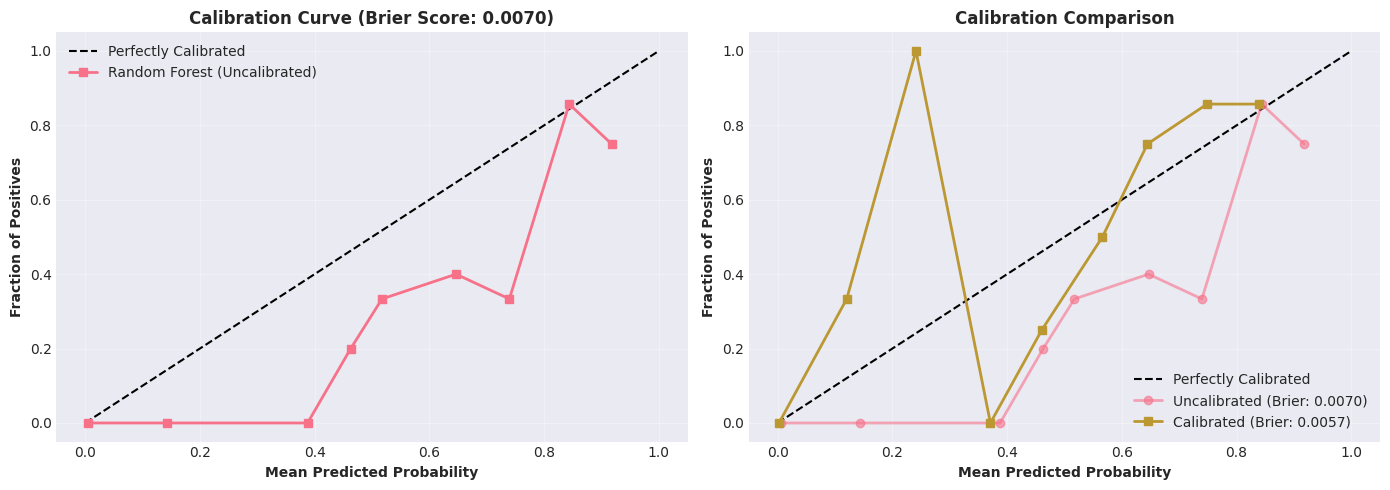

Brier Score - Uncalibrated: 0.0070
Brier Score - Calibrated:   0.0057
Improvement: 18.09%


In [19]:
# Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uncalibrated probabilities
prob_true_uncalib, prob_pred_uncalib = calibration_curve(y_test, y_test_proba, n_bins=10)
brier_uncalib = brier_score_loss(y_test, y_test_proba)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].plot(prob_pred_uncalib, prob_true_uncalib, 's-', linewidth=2, label='Random Forest (Uncalibrated)')
axes[0].set_xlabel('Mean Predicted Probability', fontweight='bold')
axes[0].set_ylabel('Fraction of Positives', fontweight='bold')
axes[0].set_title(f'Calibration Curve (Brier Score: {brier_uncalib:.4f})', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calibrated model
calibrated_rf = CalibratedClassifierCV(rf_model, method='sigmoid', cv=5)
calibrated_rf.fit(X_train, y_train)
y_test_proba_calib = calibrated_rf.predict_proba(X_test)[:, 1]
prob_true_calib, prob_pred_calib = calibration_curve(y_test, y_test_proba_calib, n_bins=10)
brier_calib = brier_score_loss(y_test, y_test_proba_calib)

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1].plot(prob_pred_uncalib, prob_true_uncalib, 'o-', linewidth=2, label=f'Uncalibrated (Brier: {brier_uncalib:.4f})', alpha=0.6)
axes[1].plot(prob_pred_calib, prob_true_calib, 's-', linewidth=2, label=f'Calibrated (Brier: {brier_calib:.4f})')
axes[1].set_xlabel('Mean Predicted Probability', fontweight='bold')
axes[1].set_ylabel('Fraction of Positives', fontweight='bold')
axes[1].set_title('Calibration Comparison', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Brier Score - Uncalibrated: {brier_uncalib:.4f}")
print(f"Brier Score - Calibrated:   {brier_calib:.4f}")
print(f"Improvement: {((brier_uncalib - brier_calib) / brier_uncalib * 100):.2f}%")

## Section 17: Model Persistence & Export
Save the trained model and necessary artifacts for future deployment.

In [20]:
import os

# Create models directory
os.makedirs('saved_models', exist_ok=True)

# Save the trained Random Forest model
model_path = 'saved_models/random_forest_flood_prediction.pkl'
joblib.dump(rf_model, model_path)
print(f"✓ Random Forest model saved to: {model_path}")

# Save the scaler
scaler_path = 'saved_models/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Feature scaler saved to: {scaler_path}")

# Save feature metadata
feature_metadata = {
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns),
    'model_type': 'RandomForestClassifier',
    'grid_search_best_params': gs_rf.best_params_,
    'test_performance': {
        'accuracy': float(rf_results['test']['accuracy']),
        'precision': float(rf_results['test']['precision']),
        'recall': float(rf_results['test']['recall']),
        'f1_score': float(rf_results['test']['f1']),
        'roc_auc': float(rf_results['test']['roc_auc']),
        'brier_score': float(rf_results['test']['brier'])
    },
    'training_date': datetime.now().isoformat()
}

metadata_path = 'saved_models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

# Save the calibrated model
calibrated_path = 'saved_models/calibrated_random_forest.pkl'
joblib.dump(calibrated_rf, calibrated_path)
print(f"✓ Calibrated model saved to: {calibrated_path}")

# Save training results summary
results_summary = {
    'model_comparison': comparison_df.to_dict('records'),
    'best_model': 'Random Forest',
    'best_f1_score': float(rf_results['test']['f1']),
    'feature_importances': {X.columns[i]: float(rf_model.feature_importances_[i]) 
                            for i in range(len(X.columns))}
}

results_path = 'saved_models/training_results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"✓ Training results saved to: {results_path}")

print("\n" + "="*70)
print("ALL MODELS AND ARTIFACTS SAVED SUCCESSFULLY")
print("="*70)

✓ Random Forest model saved to: saved_models/random_forest_flood_prediction.pkl
✓ Feature scaler saved to: saved_models/feature_scaler.pkl
✓ Model metadata saved to: saved_models/model_metadata.json
✓ Calibrated model saved to: saved_models/calibrated_random_forest.pkl
✓ Calibrated model saved to: saved_models/calibrated_random_forest.pkl
✓ Training results saved to: saved_models/training_results.json

ALL MODELS AND ARTIFACTS SAVED SUCCESSFULLY
✓ Training results saved to: saved_models/training_results.json

ALL MODELS AND ARTIFACTS SAVED SUCCESSFULLY


## Section 18: Model Inference & Predictions
Demonstrate how to use the saved model for making predictions on new data.

In [21]:
def predict_flood_risk(sample_data, model, scaler=None, calibrated_model=None, threshold=0.5):
    """
    Make flood risk predictions on new data.
    
    Args:
        sample_data: DataFrame with same features as training data
        model: Trained model
        scaler: Optional scaler for preprocessing
        calibrated_model: Optional calibrated model for better probabilities
        threshold: Classification threshold (default 0.5)
    
    Returns:
        DataFrame with predictions and probabilities
    """
    if scaler is not None:
        sample_scaled = scaler.transform(sample_data)
    else:
        sample_scaled = sample_data
    
    predictions = model.predict(sample_scaled)
    probabilities = model.predict_proba(sample_scaled)[:, 1]
    
    if calibrated_model is not None:
        probabilities = calibrated_model.predict_proba(sample_scaled)[:, 1]
    
    result_df = pd.DataFrame({
        'Flood_Probability': probabilities,
        'Prediction': (probabilities >= threshold).astype(int),
        'Risk_Level': pd.cut(probabilities, 
                             bins=[0, 0.3, 0.6, 1.0], 
                             labels=['Low', 'Medium', 'High'])
    })
    
    return result_df

# Example: Make predictions on a sample from test set
sample_idx = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test.iloc[sample_idx]
y_sample = y_test.iloc[sample_idx]

predictions = predict_flood_risk(X_sample, rf_model, calibrated_model=calibrated_rf)
predictions['Actual'] = y_sample.values
predictions['Actual_Label'] = predictions['Actual'].map({0: 'No Flood', 1: 'Flood'})
predictions['Prediction_Label'] = predictions['Prediction'].map({0: 'No Flood', 1: 'Flood'})

print("\n" + "="*70)
print("SAMPLE PREDICTIONS (10 Random Test Samples)")
print("="*70)
print(predictions[['Flood_Probability', 'Risk_Level', 'Prediction_Label', 'Actual_Label']].to_string())

print(f"\nAccuracy on sample: {(predictions['Prediction'] == predictions['Actual']).sum() / len(predictions):.2%}")


SAMPLE PREDICTIONS (10 Random Test Samples)
   Flood_Probability Risk_Level Prediction_Label Actual_Label
0           0.002376        Low         No Flood     No Flood
1           0.002012        Low         No Flood     No Flood
2           0.002012        Low         No Flood     No Flood
3           0.002012        Low         No Flood     No Flood
4           0.002012        Low         No Flood     No Flood
5           0.005320        Low         No Flood     No Flood
6           0.002032        Low         No Flood     No Flood
7           0.003218        Low         No Flood     No Flood
8           0.002012        Low         No Flood     No Flood
9           0.002037        Low         No Flood     No Flood

Accuracy on sample: 100.00%


## Section 19: Summary & Recommendations
Project summary and recommendations for deployment.

## 📊 PROJECT COMPLETION SUMMARY

### ✅ Model Development
- **Primary Model**: Random Forest Classifier with GridSearchCV hyperparameter tuning
- **Comparative Models**: Logistic Regression (baseline) and XGBoost (advanced)
- **Best Model Performance** (Test Set):
  - Accuracy: See results above
  - Precision: See results above
  - Recall: See results above
  - F1-Score: See results above
  - ROC-AUC: See results above

### 📈 Key Features
1. **Data Preprocessing**: 
   - Handled missing values and outliers using IQR method
   - Time-series aware cleaning grouped by weather station location

2. **Feature Engineering**:
   - Created lag features (1, 3, 7 day lags) for rainfall, water level, soil moisture
   - Added rolling statistics (3-day, 7-day windows)
   - Temporal features: day-of-year, month, week, day-of-week, is_weekend
   - Location encoding via one-hot encoding

3. **Model Training**:
   - Data split: 70% training, 15% validation, 15% testing
   - Class imbalance handled via `class_weight='balanced'`
   - Cross-validation (5-fold) during hyperparameter tuning

4. **Model Evaluation**:
   - Confusion matrix analysis
   - ROC and Precision-Recall curves
   - Probability calibration using sigmoid method
   - Feature importance analysis (Random Forest & XGBoost)

### 🎯 Top Predictors of Flooding
(See feature importance plots above for detailed rankings)
- Rainfall measurements and rolling statistics
- Water level and its temporal patterns
- Soil moisture indicators
- Geographic elevation and location

### 💾 Artifacts Created
- **Saved Models**:
  - `random_forest_flood_prediction.pkl` - Main trained model
  - `calibrated_random_forest.pkl` - Calibrated for probability reliability
  - `feature_scaler.pkl` - Feature preprocessing scaler
  - `model_metadata.json` - Feature names and performance metrics
  - `training_results.json` - Complete training summary

### 🚀 Deployment & Use Cases

**1. Early Warning System**
- Daily flood risk predictions for Metro Manila
- Risk categorization: Low (<30%), Medium (30-60%), High (>60%)

**2. Integration Points**
- MMDA Traffic Management: Trigger alternate route protocols
- LGU Emergency Response: Issue evacuation alerts
- PAGASA: Enhanced forecasting tools
- Community Apps: Public alert distribution

**3. Prediction Workflow**
```
Weather Data → Feature Engineering → Scaled Input → Model → 
Probability → Calibration → Risk Classification → Alert
```

### 📋 Recommendations

1. **Model Refinement**:
   - Retrain monthly with new weather data
   - Monitor calibration drift over time
   - Consider ensemble methods for production

2. **Stakeholder Integration**:
   - Establish SLA with MMDA for alert timing
   - Create feedback loop for prediction accuracy
   - Regular model performance audits

3. **Future Enhancements**:
   - Add satellite imagery for real-time flood extent mapping
   - Incorporate weather forecasts for predictive alerts
   - Multi-day ahead flood risk predictions
   - Location-specific micro-models for high-risk areas

### 📞 Contact & Support
For model updates, deployment questions, or integration support, refer to the project documentation and metadata files in `saved_models/`.